In this notebook you will find a pytorch implementation from scratch of RNN, LSTM and GRU and also a code to generate sentences.

There is also the implementation of the beam search and also the pNucleos sampling strategy.

Hope it can be helpfull for you guys!



In [ ]:
import sys
import unicodedata
import string
from typing import List
from torch.utils.data import Dataset, DataLoader
import torch
import re
import math
import copy
import os
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from itertools import chain
from torch.nn.functional import embedding, one_hot

#Text loader

In [ ]:
## Token de padding (BLANK)
PAD_IX = 0
## Token de fin de séquence
EOS_IX = 1

LETTRES = string.ascii_letters + string.punctuation + string.digits + ' '
id2lettre = dict(zip(range(2, len(LETTRES)+2), LETTRES))
id2lettre[PAD_IX] = '<PAD>' ##NULL CHARACTER
id2lettre[EOS_IX] = '<EOS>'
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))


def normalize(s):
    """ enlève les accents et les caractères spéciaux"""
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """prend une séquence de lettres et renvoie la séquence d'entiers correspondantes"""
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ prend une séquence d'entiers et renvoie la séquence de lettres correspondantes """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)


class TextDataset(Dataset):
    def __init__(self, text: str, *, maxsent=None, maxlen=None):
        """  Dataset pour les tweets de Trump
            * fname : nom du fichier
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        self.phrases = [re.sub(' +',' ',p[:maxlen]).strip() +"." for p in text.split(".") if len(re.sub(' +',' ',p[:maxlen]).strip())>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.maxlen = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, i):
        return string2code(self.phrases[i])
    

def pad_collate_fn(samples: List[List[int]]):
    #  TODO:  Renvoie un batch à partir d'une liste de listes d'indexes (de phrases) qu'il faut padder.
    
    lenght = max([len(x) for x in samples])
    out = torch.zeros((len(samples), lenght+1))
    
    
    for i, samp in enumerate(samples):
        out[i, :(samp.shape[0]+1)] = torch.cat((samp, torch.tensor([EOS_IX])))

        
    return out

#Generate

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# p_nucleus
def p_nucleus(words_proba, alpha: float):
    #  TODO:  Implémentez le Nucleus sampling ici (pour un état s)
        
    args = torch.argsort(words_proba,descending=True)
    tot = 0
    res = torch.zeros(words_proba.shape).to(device)
    for i in args:
        tot += words_proba[i]
        res[i] = words_proba[i]
        if tot >= alpha:
            break
    return res/tot

#Deterministic and probabilistic generate
def generate(rnn, emb, eos, model_name='RNN', start="I", maxlen=200, determinist=False, nucleus=False, alpha=0.95):
    """  Fonction de génération (l'embedding et le decodeur être des fonctions du rnn). Initialise le réseau avec start (ou à 0 si start est vide) et génère une séquence de longueur maximale 200 ou qui s'arrête quand eos est généré.
        * rnn : le réseau
        * emb : la couche d'embedding
        * decoder : le décodeur
        * eos : ID du token end of sequence
        * start : début de la phrase
        * maxlen : longueur maximale
    """
    #  TODO:  Implémentez la génération à partir du RNN, et d'une fonction decoder qui renvoie les logits (logarithme de probabilité à une constante près, i.e. ce qui vient avant le softmax) des différentes sorties possibles
    
    print(model_name)
    x = [0] if start=="" else [string2code(start)]
    #x = [string2code('I')]
    sentence = start

    h = torch.zeros((1,latent_space)).to(device)
    if model_name == 'LSTM':
      c = torch.zeros((1,latent_space)).to(device)
      
    for _ in range(maxlen - len(start)):
      if model_name == 'RNN':
        x_one_hot = torch.tensor(one_hot(torch.tensor(x[-1]),len(lettre2id)),dtype=torch.float).reshape((1,-1)).to(device)
      else:
        x_one_hot = torch.tensor(one_hot(torch.tensor(x[-1]),len(lettre2id)),dtype=torch.float).reshape((1,1,-1)).to(device)
        
      x_emb = emb(x_one_hot)
      if model_name != 'RNN':
        x_emb = x_emb[0]

      if model_name == 'LSTM':
        h, c = model.one_step(x_emb, h, c)
      else:
        h = model.one_step(x_emb, h)

      p_x = nn.functional.softmax(model.decode(h)[0],dim=0)

      if nucleus:
        p_x = p_nucleus(p_x, alpha)
      if determinist:
        word_idx = torch.argmax(p_x).item()
      else:
        word_idx = torch.multinomial(p_x, 1).item() # predicting the next word
      if word_idx==eos:
          return sentence
          
      sentence += id2lettre[word_idx]
      x.append(word_idx)
          
    return sentence

#Beam search

def generate_beam(rnn, emb, eos, k, model_name='RNN', start="", maxlen=200, nucleus=False, alpha=0.95):
    """  Fonction de génération (l'embedding et le decodeur être des fonctions du rnn). Initialise le réseau avec start (ou à 0 si start est vide) et génère une séquence de longueur maximale 200 ou qui s'arrête quand eos est généré.
        * rnn : le réseau
        * emb : la couche d'embedding
        * decoder : le décodeur
        * eos : ID du token end of sequence
        * start : début de la phrase
        * maxlen : longueur maximale
    """
    #  TODO:  Implémentez la génération à partir du RNN, et d'une fonction decoder qui renvoie les logits (logarithme de probabilité à une constante près, i.e. ce qui vient avant le softmax) des différentes sorties possibles
    
    print(model_name)
    x = [0] if start=="" else [string2code(start)]
    #x = [string2code('I')]
    sentence = start

    h = torch.zeros((1,latent_space)).to(device)
    if model_name == 'LSTM':
      c = torch.zeros((1,latent_space)).to(device)
      
    for _ in range(maxlen - len(start)):
      if model_name == 'RNN':
        x_one_hot = torch.tensor(one_hot(torch.tensor(x[-1]),len(lettre2id)),dtype=torch.float).reshape((1,-1)).to(device)
      else:
        x_one_hot = torch.tensor(one_hot(torch.tensor(x[-1]),len(lettre2id)),dtype=torch.float).reshape((1,1,-1)).to(device)
        
      x_emb = emb(x_one_hot)
      if model_name != 'RNN':
        x_emb = x_emb[0]

      if model_name == 'LSTM':
        h, c = model.one_step(x_emb, h, c)
      else:
        h = model.one_step(x_emb, h)

      p_x = nn.functional.softmax(model.decode(h)[0],dim=0)

      if nucleus:
        p_x = p_nucleus(p_x, alpha)

      #Beam search part
      topK_idx = torch.argsort(p_x, descending=True)[:k]
      best_idx, best_proba = 0, 0
      for idx in topK_idx:
          if model_name == 'RNN':
            idx_one_hot = torch.tensor(one_hot(torch.tensor(idx),len(lettre2id)),dtype=torch.float).reshape((1,-1)).to(device)
          else:
            idx_one_hot = torch.tensor(one_hot(torch.tensor(idx),len(lettre2id)),dtype=torch.float).reshape((1,1,-1)).to(device)
            
          x_emb = emb(idx_one_hot)
          if model_name != 'RNN':
            x_emb = x_emb[0]

          if model_name == 'LSTM':
            h1, c1 = rnn.one_step(x_emb, h, c)
          else:
            h1 = rnn.one_step(x_emb, h)
          out = rnn.decode(h1)
          best_proba_t1 = nn.functional.softmax(out[0],dim=0).max()
          if p_x[idx.item()]*best_proba_t1 > best_proba:
              best_proba = p_x[idx]*best_proba_t1
              best_idx = idx

      word_idx = best_idx.item()
      if word_idx==eos:
          return sentence
      sentence = sentence + id2lettre[word_idx]
      x.append(word_idx)
          
    return sentence

#Models

I tried my best to make a clean implementation. In the LSTM and GRU implementations, I use a "trick" that is train all the gates together and then split them. So I train them all together and then use gate.chunk() to split them to it's own gate.

In [ ]:
def maskedCrossEntropy(output: torch.Tensor, target: torch.LongTensor, padcar: int):
    """
    :param output: Tenseur length x batch x output_dim,
    :param target: Tenseur length x batch
    :param padcar: index du caractere de padding
    """
    #  TODO:  Implémenter maskedCrossEntropy sans aucune boucle, la CrossEntropy qui ne prend pas en compte les caractères de padding.
    mask = torch.where(target == padcar, 0, 1)
    loss = CrossEntropyLoss(reduce=None)
    
    return torch.sum(loss(output,target)*mask)/mask.sum()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):

        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size  = output_size
        self.input_size = input_size

        self.encode = nn.Linear(input_size+hidden_size, hidden_size)
        self.decode_latent = nn.Linear(hidden_size, output_size)
    
    def decode(self,h):
        return self.decode_latent(h)

    def predict(self,outs):
        return torch.argmax(torch.softmax(outs, dim=0), dim=1)
    
    def predict_proba(self,outs):
        #return torch.argsort(torch.softmax(outs, dim=1), descending = True)[:k]
        return torch.softmax(outs, dim=0)
        
    def one_step(self, x, h):
        x_h = torch.cat((x, h), axis=1)
        return torch.sigmoid(self.encode(x_h))

    def forward(self, x):

        # Initialize hidden state for first iteration
        h = torch.zeros((x.shape[0], self.hidden_size)).to(x.device)
        hidden_states = []

        # Iterative forward
        for i in range(x.shape[1]):
            h = self.one_step(x[:,i], h)
            hidden_states.append(h)
            
        return torch.stack(hidden_states)


class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):

        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        #W corresponds to Wf, Wi, Wo and Wc, and the same for U.
        
        self.W = nn.Linear(input_size, 4 * hidden_size, bias=True)
        self.U = nn.Linear(hidden_size, 4 * hidden_size, bias=True)


    def forward(self, x, h, c):
        
        gates = self.W(x) + self.U(h)

        # Get gates (i_t, f_t, g_t, o_t)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = self.sigmoid(input_gate)
        f_t = self.sigmoid(forget_gate)
        g_t = self.tanh(cell_gate)
        o_t = self.sigmoid(output_gate)

        cy = c * f_t + i_t * g_t

        hy = o_t * self.tanh(cy)

        return hy, cy
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size


        self.rnnCell = LSTMCell(self.input_size, self.hidden_size)
        
        self.fc = nn.Linear(self.hidden_size, self.output_size)
  
    def one_step(self, x, h, c):
        h, c = self.rnnCell(x, h, c)
        return h, c

    def decode(self,h):
        return self.fc(h)

    def forward(self, x):

        h = torch.zeros(x.shape[0], self.hidden_size).to(x.device)
        c = torch.zeros(x.shape[0], self.hidden_size).to(x.device)
        
        hidden_states = []
        c_states = []
        
        #for all words/time stemps
        for t in range(x.shape[1]):
            #If you want more than 1 layer
            for layer in range(self.num_layers):
                h, c = self.one_step(x[:,t], h, c)
                hidden_states.append(h)
                c_states.append(c)
        
        return torch.stack((torch.stack(hidden_states),torch.stack(c_states)))


class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):

        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        #W corresponds to Wz, Wr and Wh, and the same for U.
        
        self.W = nn.Linear(input_size, 3 * hidden_size, bias=True)
        self.U = nn.Linear(hidden_size, 3 * hidden_size, bias=True)


    def forward(self, x, h):
        
        x_t = self.W(x)
        h_t = self.U(h)

        # As I have Wz, Wr and Wh on W and the same for U, I need to chunk them
        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)
        
        #Setting the gates
        reset_gate = self.sigmoid(x_reset + h_reset)
        update_gate = self.sigmoid(x_upd + h_upd)
        new_gate = self.tanh(x_new + (reset_gate * h_new))

        #Next state
        hy = update_gate * h + (1 - update_gate) * new_gate

        return hy

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size


        self.rnnCell = GRUCell(self.input_size, self.hidden_size)
        
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def one_step(self, x, h):
        h = self.rnnCell(x, h)
        return h

    def decode(self,h):
        return self.fc(h)

    def forward(self, x):

        h = torch.zeros(x.shape[0], self.hidden_size).to(x.device)
        
        hidden_states = []
        
        #for all words/time stemps
        for t in range(x.shape[1]):
            #If you want more than 1 layer
            for layer in range(self.num_layers):
                h = self.one_step(x[:,t], h)
                hidden_states.append(h)
        
        return torch.stack(hidden_states)

# Learning

Activate the google colab GPU or your GPU, otherwise it will take too long to train. Don't forget to choose the model, you can choose between RNN, LSTM and GRU.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
device

'cuda'

In [ ]:
LEN_GENERATION = 20
MAX_SENT = 100
latent_space = 128 # taille de l'espace latent caché
embedding_space = 64

batch_size = 64

#Download and open the data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1aHpZ_ZmER10OMQE2pXvz93algzuxIhMI',
                                    dest_path='./trump_full_speech.txt')

with open('trump_full_speech.txt','r') as file:
    speech = file.read().replace('\n', '')

dataset = TextDataset(speech, maxlen = MAX_SENT)
train_set = DataLoader(dataset, collate_fn=pad_collate_fn, batch_size=batch_size)

#Choose the model

#model, model_name = RNN(embedding_space, latent_space, len(LETTRES)+2).to(device), 'RNN'
#model, model_name = GRU(embedding_space, latent_space, 1,  len(LETTRES)+2).to(device), 'GRU'
model, model_name = LSTM(embedding_space, latent_space, 1,  len(LETTRES)+2).to(device), 'LSTM'

train = True

# if model_name in os.listdir():
#   model.load_state_dict(torch.load(model_name))
#   train=False

nepochs = 30
#a linear projection from the one hot encoding to the embedding space
embedding = nn.Linear(len(lettre2id), embedding_space).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(chain(model.parameters(), embedding.parameters()),lr=0.003)# it learn both the RNN for generation and the embeding function


In [ ]:
if train:
  best_loss = 10000000000
  l=[]
  for epoch in range(nepochs):
      # print("epoch",epoch)
      L=0
      for i, x in enumerate(train_set):
          y = x[:,1:].to(device)
          x = x[:,:-1].to(device)
          x_one_hot = torch.tensor(one_hot(x.to(torch.int64), len(LETTRES)+2),dtype=torch.float, requires_grad=True)

          optimizer.zero_grad()
          x_emb = embedding(x_one_hot)
          
          if model_name == 'LSTM':
            h, c = model(x_emb)
          else:
            h = model(x_emb)

          h = h.transpose(0, 1)
          h = h.reshape(-1, h.shape[2])
          outs = model.decode(h)

          loss = maskedCrossEntropy(outs, y.flatten().long(), padcar = PAD_IX)
          with torch.no_grad():
              loss.backward()
              optimizer.step()
              L += loss.item()
      print("Epoch:", epoch, "loss:", L/i)
      if L/i < best_loss:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss=L/i
      l.append(L/i)


  torch.save(best_model_wts, model_name)

Epoch: 0 loss: 3.1437029196665836
Epoch: 1 loss: 2.193857729434967
Epoch: 2 loss: 1.9736777039674611
Epoch: 3 loss: 1.8837000039907603
Epoch: 4 loss: 1.7165221067575307
Epoch: 5 loss: 1.6205674914213328
Epoch: 6 loss: 1.564539936872629
Epoch: 7 loss: 1.5233677075459406
Epoch: 8 loss: 1.4892666248174815
Epoch: 9 loss: 1.4584157168865204
Epoch: 10 loss: 1.4289161952642293
Epoch: 11 loss: 1.4003177629067347
Epoch: 12 loss: 1.3730718332987566
Epoch: 13 loss: 1.3467573729845195
Epoch: 14 loss: 1.320893631531642
Epoch: 15 loss: 1.2960148660036235
Epoch: 16 loss: 1.2724103446190174
Epoch: 17 loss: 1.2498757793353155
Epoch: 18 loss: 1.2286934646276326
Epoch: 19 loss: 1.2090358481957362
Epoch: 20 loss: 1.1906669048162608
Epoch: 21 loss: 1.1732043004952943
Epoch: 22 loss: 1.1566907786406004
Epoch: 23 loss: 1.1409386877830212
Epoch: 24 loss: 1.1258619794478784
Epoch: 25 loss: 1.111381817322511
Epoch: 26 loss: 1.0975303099705622
Epoch: 27 loss: 1.0843378924406493
Epoch: 28 loss: 1.0717724882639372

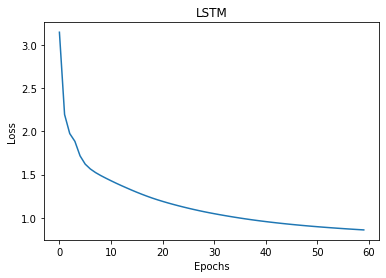

In [ ]:
if train:
  plt.plot(l)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(model_name)
  plt.show();

#Generate

Here you can play with the starting word or sentence and see different results by setting determinist = False.

In [ ]:
generate(model, embedding, EOS_IX, model_name, start="T", determinist=False)

LSTM


"They're uplane, olly get mrone, vote and Russ, we've seez in this dealth."

# Beam search

Here you can play with the starting letter or sentence, K, the pNucleos... And you can also test different methods.

In [ ]:
generate_beam(model, embedding, EOS_IX, 1, model_name, start="H",  nucleus=True)

LSTM


'Hillary Clinton is the policies and the policies and the policies and the policies and the policies and the policies and the policies and the policies and the policies and the policies and the policie'